# **Andrej Karpathy Micrograd Tutorial**
# [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)
___

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR: left -> right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for value - create rectangular 'record' node
        dot.node(name=uid, 
                 label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}", 
                 shape='record'
                )
        
        # if result of an operation, create operator node
        if n._op:
            dot.node(name=uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1,n2 in edges:
        # connect n1 -> op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [3]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        # function which will backpropagate
        # based on chain rule
        self._backward = lambda : None
        
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out


## To do the backpropagation, we need to follow a sequence of nodes in the equation backwards

## this ordering can be achieved through topological sort -- all the edges go in one direction


![topological sort](https://i.imgur.com/jdNVsfi.png)

[image credits](https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95)


In [4]:
# 2D input:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# output
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

In [5]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8813),
 Value(data=0.8813000000000004),
 Value(data=0.7070699857622339)]

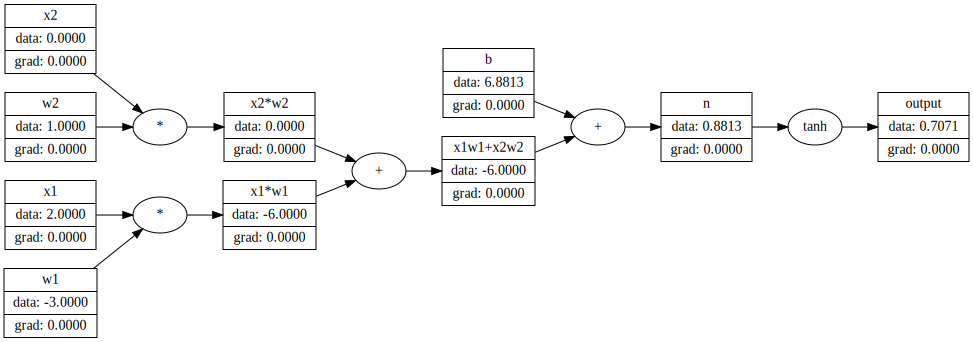

In [6]:
draw_dot(o)

# Automatic Backpropagation

In [7]:
# backprop

o.grad = 1.0

for node in reversed(topo):
    node._backward()

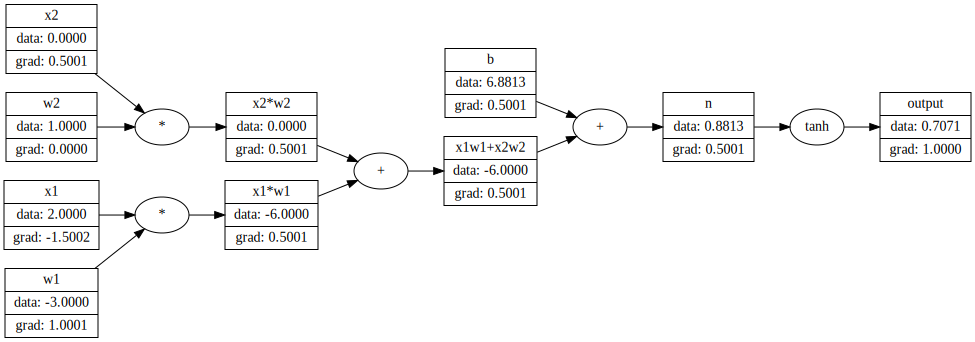

In [8]:
draw_dot(o)

# Wrapping the sort and backward call in Value class

In [9]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        # function which will backpropagate
        # based on chain rule
        self._backward = lambda : None
        
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)


        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
# 2D input:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# output
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

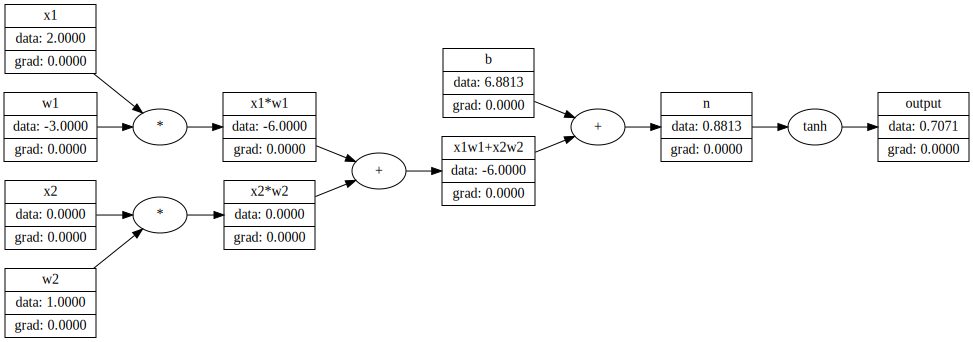

In [11]:
draw_dot(o)

In [12]:
o.backward()

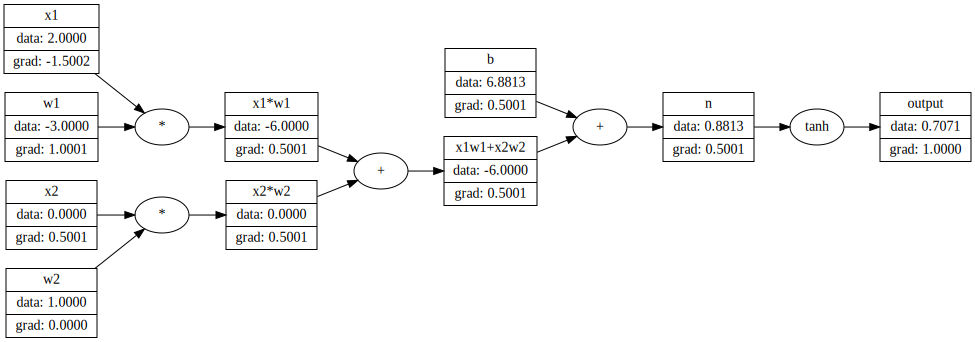

In [13]:
draw_dot(o)

___

# Bug: using the same node multiple times

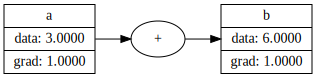

In [14]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'

b.backward()
draw_dot(b)

```
b = a + a
db/da = 1 + 1 = 2
but in the above graph the grad = 1
```

since a is used twice, self and other in `__add__()` is the same value object so its being rewritten.

so every time a variable is >1, the issue persists

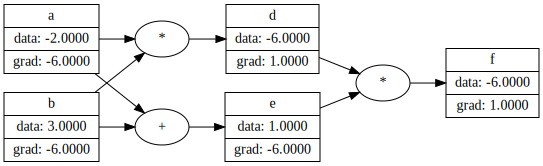

In [15]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b
d.label = 'd'
e = a+b
e.label = 'e'
f = d*e
f.label = 'f'

f.backward()
draw_dot(f)

### according to the chain rule, the way to combat this problem is to accumulate gradients.

So instead of setting (=) we accumulate (+=)

# Correct Automatic Backpropagation

In [16]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        # function which will backpropagate
        # based on chain rule
        self._backward = lambda : None
        
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)


        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

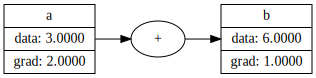

In [17]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'

b.backward()
draw_dot(b)

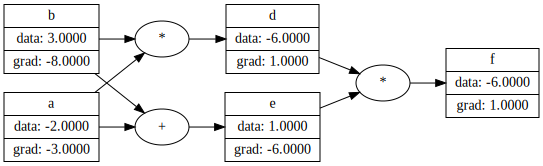

In [18]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b
d.label = 'd'
e = a+b
e.label = 'e'
f = d*e
f.label = 'f'

f.backward()
draw_dot(f)

___

# Improving the Value object

In [19]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        # function which will backpropagate
        # based on chain rule
        self._backward = lambda : None
        
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # wrap other in Value obj if its not a value obj
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += ((other) * self.data**(other-1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)


        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [20]:
# so now we can do stuff like this:

a = Value(2.0)
b = Value(3.0)
a + 1, b*2

(Value(data=3.0), Value(data=6.0))

In [21]:
# but 2 * a and 1 + b, wont wont since 2.__mul__(a) and 1.__add__(b) is invalid
# to solve this we can add __rmul__ and __radd__ which swap the operands, to the Value obj

2 * a, -5 + b

(Value(data=4.0), Value(data=-2.0))

## adding exponent to Value
`.exp()`
```
if there are 4 vars: a,b,c,d
b = e**a
db/da = e**a
d = b + c
dd/db = 1
dd/dc = 1

therefore by chain rule:
dd/da = dd/db * db/da
```

## Adding Division to Value
`__truediv__()`

```
c = a/b
c = a * (1/b)
c = a * (b**1)
```

In [22]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [23]:
a = Value(4)
-a - 3

Value(data=-7)

## Redefining how we calculate tanh instead of tanh(), we'll use exp,add,sub,div

In [24]:
# 2D input:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# output
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

# o = n.tanh()

e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'output'

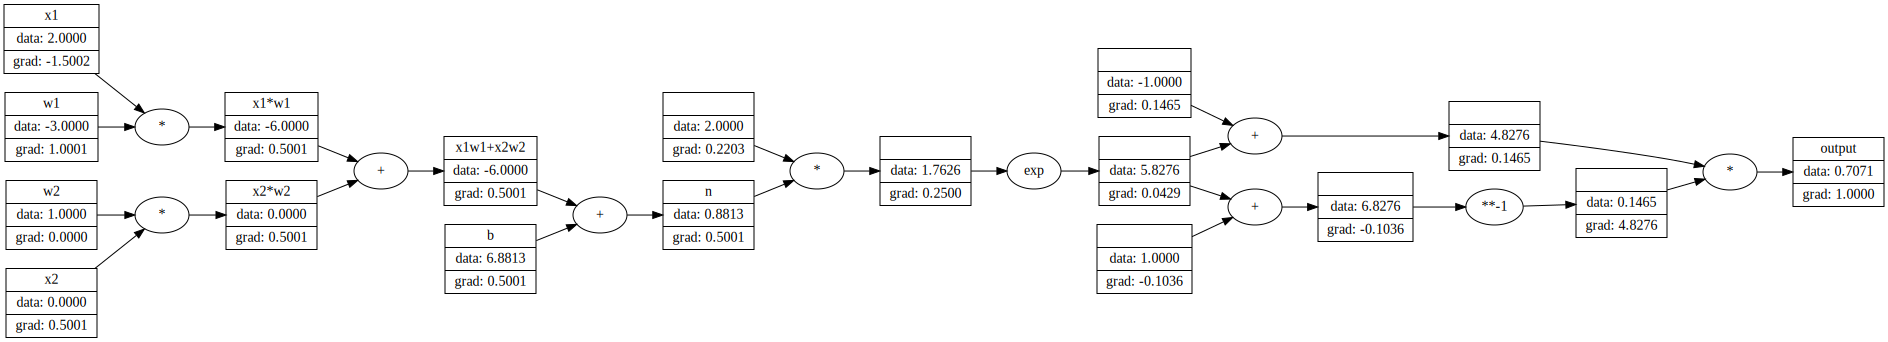

In [25]:
o.backward()
draw_dot(o)